# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [1]:
!pip install grad-cam
!pip install medmnist

In [14]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image


from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM, LayerCAM, FullGrad, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_grad_cam.metrics.perturbation_confidence import PerturbationConfidenceMetric
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst

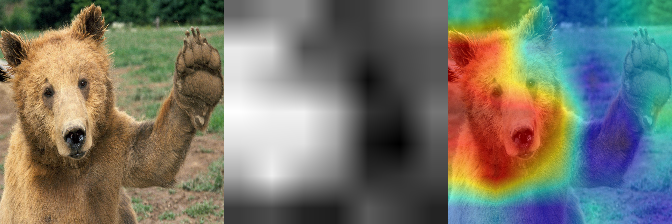

In [56]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import torch.nn as nn

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
# img = cv2.imread("C:\\Users\\m1choelz\\Downloads\\bear.jpg")
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.010518974158912897
The visualization of the pertubated image for the metric:


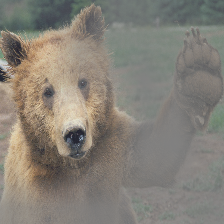

In [57]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

In [9]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

print("Is CUDA available? ", cuda_available)

# If CUDA is available, you can also print the number of GPUs and their names
if cuda_available:
    print("Number of GPUs available: ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("GPU ", i, ": ", torch.cuda.get_device_name(i))

Is CUDA available?  True
Number of GPUs available:  1
GPU  0 :  NVIDIA RTX A3000 Laptop GPU


100%|██████████| 64/64 [02:31<00:00,  2.36s/it]


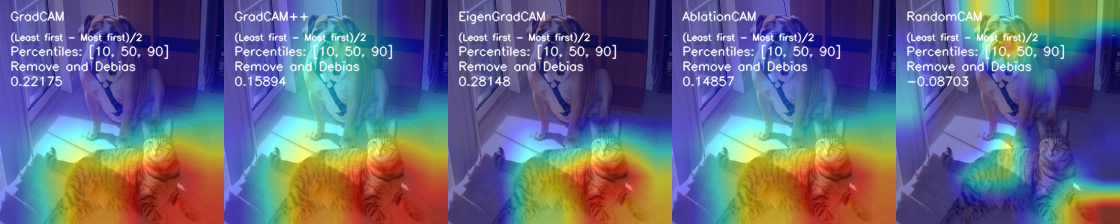

In [59]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM, LayerCAM, FullGrad, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers)),

               ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

# cat_and_dog_image_url = "C:\\Users\\m1choelz\\Downloads\\both.jpg"
# cat_and_dog = cv2.imread(cat_and_dog_image_url)
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

# model.cuda()
# input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


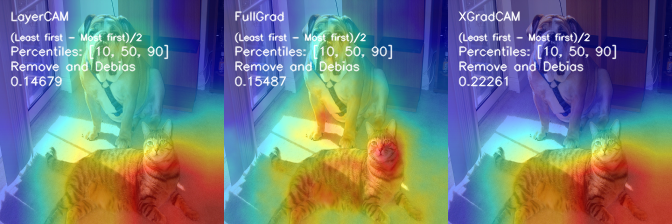

In [60]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM, LayerCAM, FullGrad, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [
               ("LayerCAM", LayerCAM(model=model, target_layers=target_layers)),
               ("FullGrad", FullGrad(model=model, target_layers=target_layers)),
               ("XGradCAM", XGradCAM(model=model, target_layers=target_layers))
               ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        print(cat_and_dog.shape)
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

# cat_and_dog_image_url = "C:\\Users\\m1choelz\\Downloads\\both.jpg"
# cat_and_dog = cv2.imread(cat_and_dog_image_url)
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

# model.cuda()
# input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [126]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.utils.data as data

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of
# them are compatible with the standard torchvision models
data_flag = "pathmnist" #'pathmnist' #'breastmnist'#'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
# You are expected to create the appropriate dataloaders to be used for training, testing and validation
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
#model = models.resnet50(pretrained=True)
train_loader = data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = data.DataLoader(dataset=test_set, batch_size=64, shuffle=False)
valid_loader = data.DataLoader(dataset=val_set, batch_size=64, shuffle=False)


Using downloaded and verified file: C:\Users\m1choelz\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\m1choelz\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\m1choelz\.medmnist\pathmnist.npz


Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 3421
    Root location: C:\Users\Sama\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

Dataset PathMNIST (pathmnist)
    Number of datapoints: 7180
    Root location: C:\Users\m1choelz\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
    License: CC BY 4.0


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: C:\Users\m1choelz\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0

In [84]:
print(test_set)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: C:\Users\m1choelz\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


In [78]:

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer6 = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid())


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 32*3*3)
        x = self.layer6(x)
        return x


# define the BCE loss function and an optimizer you prefer
criterion = nn.BCELoss()
model = models.resnet50(pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-03)
#model = CNN(in_channels=1, num_classes=2)

### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [64]:
import time
import numpy as np
from sklearn.metrics import jaccard_score


def generate_cam(cam_method, cam_metric, input_tensor, targets, metric_targets):
    start_time = time.time()  # Start timing for efficiency evaluation

    with cam_method:
        attributions = cam_method(input_tensor=input_tensor, targets=targets, eigen_smooth=False, aug_smooth=False)
    
    elapsed_time = time.time() - start_time  # Time taken for CAM generation
    
    grayscale_cam = attributions[0, :]
    img = input_tensor[0].cpu().numpy().transpose(1, 2, 0)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    scores = cam_metric(input_tensor, attributions, metric_targets, model)
    score = scores[0]
    
    return cam_image, score, elapsed_time

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget


In [97]:

def continuous_explanation( model, loader, device, epoch, mode):
    model.eval()  # Set model to evaluation mode for explanation
    target_layers = [model.layer3]
    # target_layers = get_bias_layers(model)
    # print(target_layers)


    for batch, (data, target) in enumerate(loader):
        visualizations = []
        if batch > 0 and mode != 'test': break  # Limit to one batch for demonstration
        data = data.to(device)
        pred = model(data)
        predicted_class = pred.argmax(dim=1)[0].item()
        actual_class = target[0].item()

        # Process a single image for CAM
        input_tensor = data[0:1]  # Keep the batch dimension as 1
        targets = [ClassifierOutputTarget(predicted_class)]
        #targets = [ClassifierOutputSoftmaxTarget(predicted_class)]
        # print(predicted_class)
        metric_targets = [ClassifierOutputTarget(predicted_class)]
        methods = [
            #("GradCAM", GradCAM(model=model, target_layers = target_layers)),
            ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
            ("LayerCAM", LayerCAM(model=model, target_layers=target_layers)),
           ("FullGrad", FullGrad(model=model, target_layers=target_layers)),
        #    ("XGradCAM", XGradCAM(model=model, target_layers=target_layers))
        #    ("EigenGradCAM",EigenGradCAM(model=model, target_layers=target_layers)), 
            ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)), 
            #("RandomCAM",RandomCAM(model=model, target_layers=target_layers)),
            ]
        cam_performance = {}  
        # Generate CAM for the specified methods
        # cam_metric = CamMultImageConfidenceChange()
        for name, cam_method in methods:
            # cam_metric = CamMultImageConfidenceChange()
            cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
            metric_name = "ROAD "
            #cam_metric = CamMultImageConfidenceChange()
            #metric_name = "ConfidenceChangeAfterSofmax"
            # # cam_metric = ROADMostRelevantFirst(percentile=75)
            # cam_image, score = generate_cam(cam_method, cam_metric, input_tensor, targets, metric_targets)
            # # visualization = add_text_to_image(cam_image, name)
            cam_image, score, time_taken = generate_cam(cam_method, cam_metric, input_tensor, targets, metric_targets)
            rounded_score = "{:.2f}".format(score)
            visualizations.append((name, cam_image, rounded_score))

        # Store performance data
            if name not in cam_performance:
                cam_performance[name] = {'time': [], 'score': []}
            cam_performance[name]['time'].append(time_taken)
            cam_performance[name]['score'].append(score)

        # Display the original image and CAM visualizations
        display_images(data, visualizations, epoch, batch, predicted_class, actual_class, mode)
        plt.pause(0.005)  # Pause to update plots
    for method in cam_performance:
        print(method)
        avg_time = sum(cam_performance[method]['time']) / len(cam_performance[method]['time'])
        avg_score = sum(cam_performance[method]['score']) / len(cam_performance[method]['score'])
        print(f"{method} - Average Time: {avg_time}, Average {metric_name} Score: {avg_score}")

    model.train()  # Set model back to training mode



def add_text_to_image(image, text):
    return cv2.putText(image, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

def display_images(data, visualizations, epoch, batch, predicted_class, actual_class, mode):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(visualizations) + 1, 1)

    if data.shape[1] == 3:
        img_np = data[0].cpu().numpy().transpose(1, 2, 0)
        original_img = (img_np -  np.min(img_np)) / (np.max(img_np) - np.min(img_np))  # Normalize
        plt.imshow(original_img)
    else:
        
        plt.imshow(data[0].cpu().squeeze(), cmap='gray')
    plt.title('Original Image')
    for i, (name,visualization,score) in enumerate(visualizations):
        plt.subplot(1, len(visualizations) + 1, i+2)
        plt.imshow(visualization)
        if mode == 'test':
            plt.title(f'{name}\n Batch {batch+1}\nPredicted: {predicted_class}, Actual: {actual_class}\n  Metric_score {score}')
        else:
            plt.title(f'{name}\nEpoch {epoch+1}, Batch {batch+1}\nPredicted: {predicted_class}, Actual: {actual_class}\n Metric_score {score}')
    plt.show()


In [70]:
# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')


    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []
        model.train()
        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target.long())

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if i % 20 == 0:  # Explanation every 20 batches
             #   continuous_explanation(model, valid_loader, device, epoch, 'val')

        # Validation step
        continuous_explanation(model, valid_loader, device, epoch, 'val')
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                image, target = data.to(device), target.to(device)
                pred = model(image)
                loss = criterion(pred, target.long())
                valid_losses.append(loss.item())
                # does work yet:
                #continuous_explanation(model, valid_loader, device, epoch, 'val')
        # Model saving based on vlaidation loss:
        avg_val_loss = np.mean(valid_losses)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')


        # We suggest you modify this code to run the continuous explanations
        # print(f"Grad-cam testing")
        # target_layers = [model.layer4]

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )
    return model

In [124]:
import matplotlib.pyplot as plt

def test(model, device, data_loader, mean=0.5432, std=0.2731):
    model.eval()
    preds = []
    pred_list = []
    correct = 0

    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = image.to(device)
            target = target

            output = model(images).detach().cpu()
            print(output.shape)
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"Grad-cam testing")
    # target_layers = [model.layer4]  # Replace with your model's specific layer
    # cam = GradCAM(model=model, target_layers=target_layers)

    #target_layers = None
    #with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        #pass
    continuous_explanation( model, data_loader, device, 0, 'test')



    return np.concatenate(pred_list)

cuda


Training-loop: 100%|██████████| 1407/1407 [01:33<00:00, 15.04it/s]


100%|██████████| 32/32 [00:00<00:00, 104.96it/s]


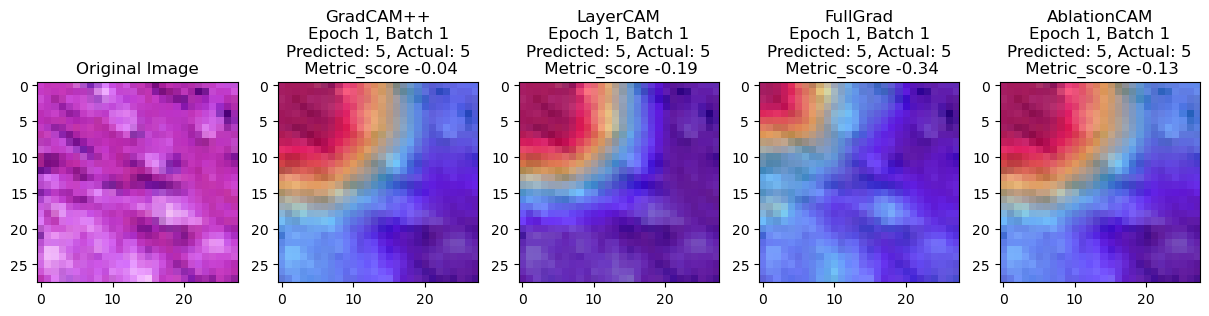

GradCAM++
GradCAM++ - Average Time: 0.0360875129699707, Average ROAD  Score: -0.042998552322387695
LayerCAM
LayerCAM - Average Time: 0.03200721740722656, Average ROAD  Score: -0.1893606185913086
FullGrad
FullGrad - Average Time: 0.4655759334564209, Average ROAD  Score: -0.3433263301849365
AblationCAM
AblationCAM - Average Time: 0.32288646697998047, Average ROAD  Score: -0.12939298152923584


Validation-loop: 100%|██████████| 157/157 [00:03<00:00, 51.02it/s]


Train Epoch: 1 Loss: 0.791286 Validation loss: 14.093959 Acc: 75.443837 


Training-loop: 100%|██████████| 1407/1407 [01:32<00:00, 15.15it/s]


100%|██████████| 32/32 [00:00<00:00, 65.21it/s]


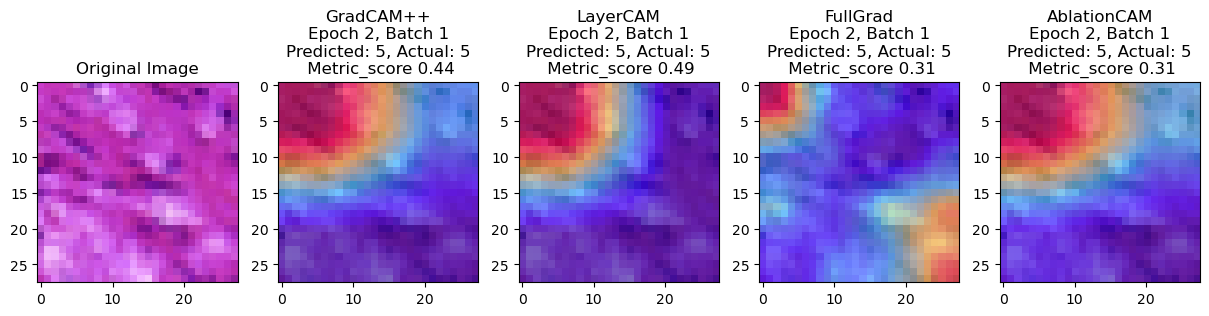

GradCAM++
GradCAM++ - Average Time: 0.03200244903564453, Average ROAD  Score: 0.44271743297576904
LayerCAM
LayerCAM - Average Time: 0.02999567985534668, Average ROAD  Score: 0.4857746362686157
FullGrad
FullGrad - Average Time: 0.5208559036254883, Average ROAD  Score: 0.3108675479888916
AblationCAM
AblationCAM - Average Time: 0.5077929496765137, Average ROAD  Score: 0.31492650508880615


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 32.84it/s]


Train Epoch: 2 Loss: 0.478178 Validation loss: 46.730645 Acc: 83.336665 


Training-loop: 100%|██████████| 1407/1407 [12:34<00:00,  1.87it/s]


100%|██████████| 32/32 [00:00<00:00, 53.90it/s]


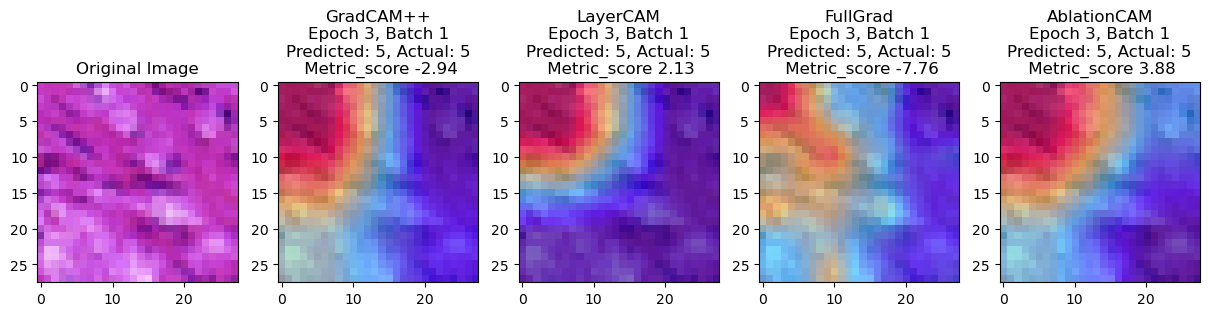

GradCAM++
GradCAM++ - Average Time: 0.05500054359436035, Average ROAD  Score: -2.9406673908233643
LayerCAM
LayerCAM - Average Time: 0.0405275821685791, Average ROAD  Score: 2.1318674087524414
FullGrad
FullGrad - Average Time: 0.5040061473846436, Average ROAD  Score: -7.759631156921387
AblationCAM
AblationCAM - Average Time: 0.6197452545166016, Average ROAD  Score: 3.875945568084717


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 32.90it/s]


Train Epoch: 3 Loss: 0.370783 Validation loss: 2.680433 Acc: 87.193497 


Training-loop: 100%|██████████| 1407/1407 [11:56<00:00,  1.96it/s]


100%|██████████| 32/32 [00:00<00:00, 51.62it/s]


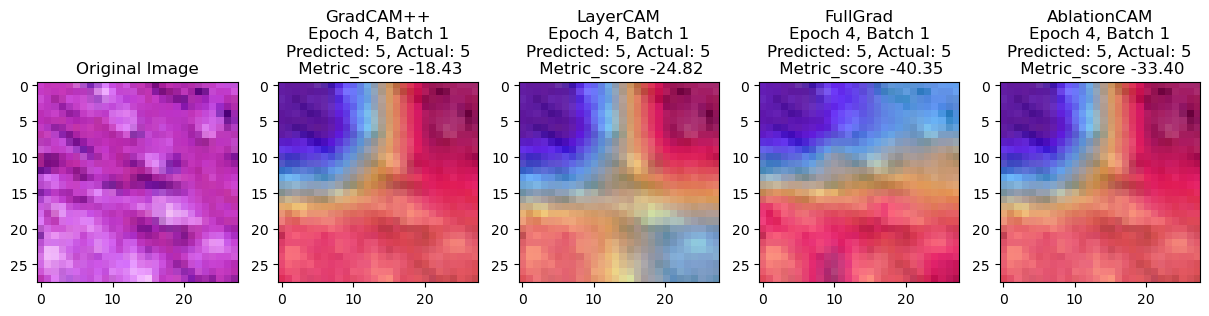

GradCAM++
GradCAM++ - Average Time: 0.050997257232666016, Average ROAD  Score: -18.425376892089844
LayerCAM
LayerCAM - Average Time: 0.0390012264251709, Average ROAD  Score: -24.82139015197754
FullGrad
FullGrad - Average Time: 0.5117897987365723, Average ROAD  Score: -40.34779739379883
AblationCAM
AblationCAM - Average Time: 0.6418721675872803, Average ROAD  Score: -33.39746856689453


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Train Epoch: 4 Loss: 0.385760 Validation loss: 7.667396 Acc: 86.459814 


Training-loop: 100%|██████████| 1407/1407 [12:39<00:00,  1.85it/s]


100%|██████████| 32/32 [00:00<00:00, 49.98it/s]


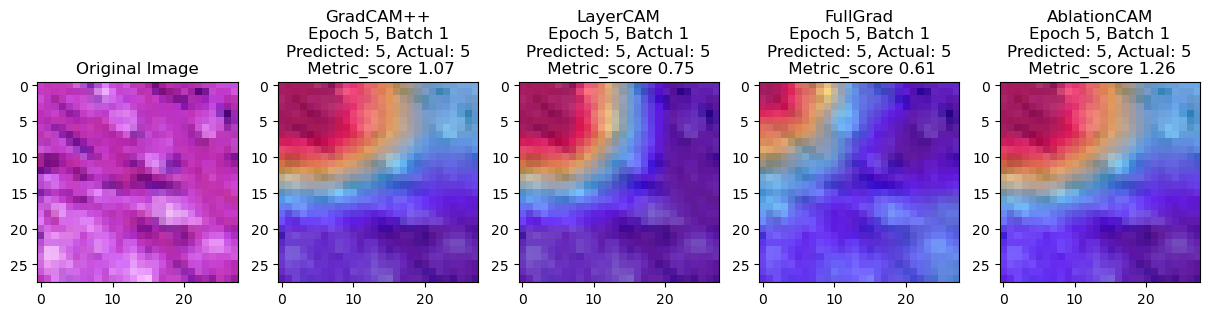

GradCAM++
GradCAM++ - Average Time: 0.052361249923706055, Average ROAD  Score: 1.0671515464782715
LayerCAM
LayerCAM - Average Time: 0.040676116943359375, Average ROAD  Score: 0.7482352256774902
FullGrad
FullGrad - Average Time: 0.5791149139404297, Average ROAD  Score: 0.6112246513366699
AblationCAM
AblationCAM - Average Time: 0.660423755645752, Average ROAD  Score: 1.257282018661499


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 33.49it/s]


Train Epoch: 5 Loss: 0.267337 Validation loss: 1.389308 Acc: 90.708659 


Training-loop: 100%|██████████| 1407/1407 [12:54<00:00,  1.82it/s]


100%|██████████| 32/32 [00:00<00:00, 54.03it/s]


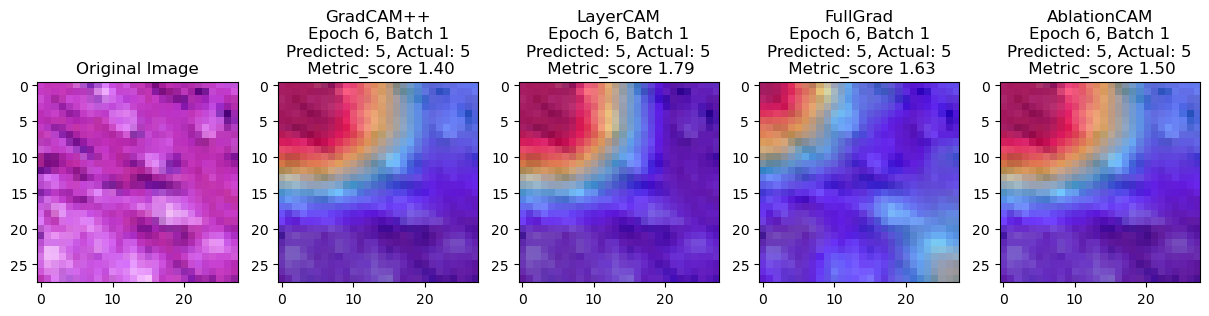

GradCAM++
GradCAM++ - Average Time: 0.047033071517944336, Average ROAD  Score: 1.3995201587677002
LayerCAM
LayerCAM - Average Time: 0.03761911392211914, Average ROAD  Score: 1.7909588813781738
FullGrad
FullGrad - Average Time: 0.5099103450775146, Average ROAD  Score: 1.627050757408142
AblationCAM
AblationCAM - Average Time: 0.6172866821289062, Average ROAD  Score: 1.4985105991363525


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 33.02it/s]


Train Epoch: 6 Loss: 0.211807 Validation loss: 0.756988 Acc: 92.555452 


Training-loop: 100%|██████████| 1407/1407 [13:09<00:00,  1.78it/s]


100%|██████████| 32/32 [00:00<00:00, 49.62it/s]


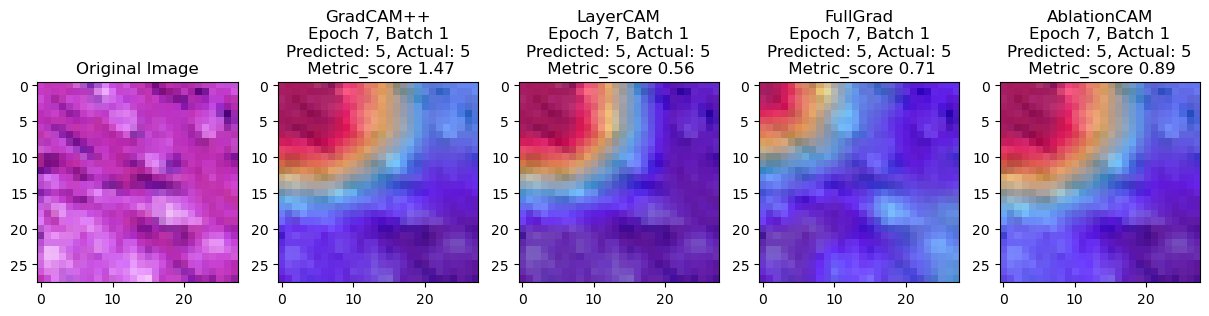

GradCAM++
GradCAM++ - Average Time: 0.04880475997924805, Average ROAD  Score: 1.4699573516845703
LayerCAM
LayerCAM - Average Time: 0.042236328125, Average ROAD  Score: 0.5634089708328247
FullGrad
FullGrad - Average Time: 0.5403461456298828, Average ROAD  Score: 0.710608959197998
AblationCAM
AblationCAM - Average Time: 0.6658926010131836, Average ROAD  Score: 0.8923766613006592


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 32.60it/s]


Train Epoch: 7 Loss: 0.193248 Validation loss: 2.507608 Acc: 93.276179 


Training-loop: 100%|██████████| 1407/1407 [13:48<00:00,  1.70it/s]


100%|██████████| 32/32 [00:00<00:00, 50.51it/s]


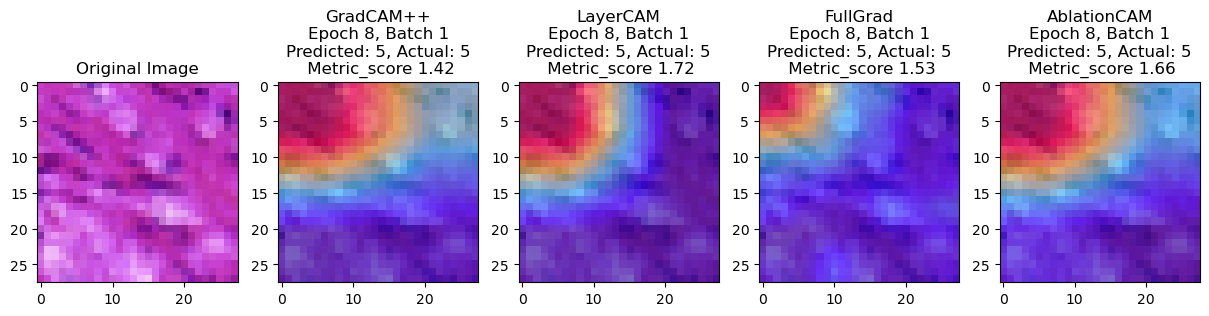

GradCAM++
GradCAM++ - Average Time: 0.04850459098815918, Average ROAD  Score: 1.4188287258148193
LayerCAM
LayerCAM - Average Time: 0.04660606384277344, Average ROAD  Score: 1.7203763723373413
FullGrad
FullGrad - Average Time: 0.5597794055938721, Average ROAD  Score: 1.5325266122817993
AblationCAM
AblationCAM - Average Time: 0.6525402069091797, Average ROAD  Score: 1.660040020942688


Validation-loop: 100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Train Epoch: 8 Loss: 0.178190 Validation loss: 0.321378 Acc: 93.847726 


Training-loop:  57%|█████▋    | 800/1407 [08:12<05:52,  1.72it/s]

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet50(pretrained=True)
model = train(device, model, train_loader, 10, 3e-03)

In [125]:
test(model, device, test_loader)

Test-loop:   0%|          | 0/113 [00:00<?, ?it/s]

torch.Size([32, 1000])


ValueError: operands could not be broadcast together with shapes (32,) (64,) 